# Analyse Morris results

In [5]:
import pandas as pd
import seaborn as sns
import re

Run with `dakota -i ia.in > morris_3p_summary.out`: only `>` gets results written to file.

In [6]:
# Must be am easier way to get Dakota results out...
# Read in .out file (contains summary results)
with open("morris_3p_summary.out", "r") as f:
    content = f.readlines()

# Match line in output
input_re = re.compile(r"Input\s+(\d+)\s.*=\s+(\d+\.\d+e[+-]\d+)\s+(\d+\.\d+e[+-]\d+)")
results = {"input": [], "mod_mean": [], "std": []}
for line in content:
    if matches := input_re.match(line):
        # Start of results
        results["input"].append(float(matches[1]))
        results["mod_mean"].append(float(matches[2]))
        results["std"].append(float(matches[3]))
    else:
        continue

results_df = pd.DataFrame(results)
results_df

,input,mod_mean,std
0,1.0,0.000000,0.000000
1,2.0,0.000000,0.000000
2,3.0,0.000000,0.000000
3,4.0,0.000000,0.000000
4,5.0,0.873840,0.954550
5,6.0,0.000000,0.000000
6,7.0,0.294510,0.372450
7,8.0,0.168370,0.389250
8,9.0,0.000000,0.000000
9,10.0,0.333450,0.517750


Text(0, 0.5, '$\\sigma$')

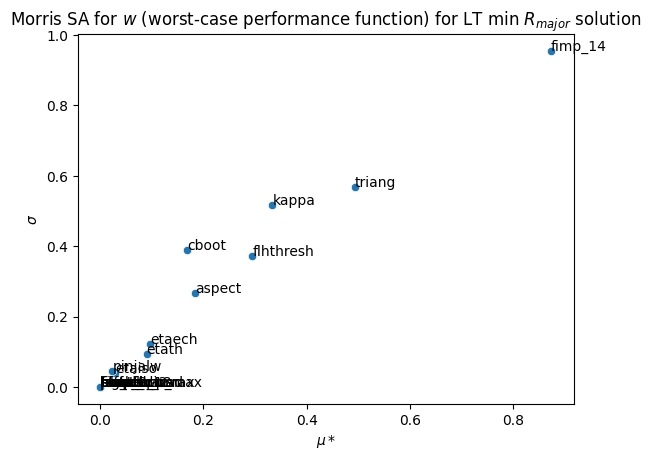

In [27]:
ax = sns.scatterplot(data=results_df, x="mod_mean", y="std")

x_offset = 0.0
y_offset = 0.0

descriptors = [
    "fdene",
    "hfact",
    "coreradius",
    "fimp_2",
    "fimp_14",
    "psepbqarmax",
    "flhthresh",
    "cboot",
    "peakfactrad",
    "kappa",
    "etaech",
    "feffcd",
    "etath",
    "etaiso",
    "boundl_18",
    "pinjalw",
    "alstroh",
    "sig_tf_wp_max",
    "aspect",
    "boundu_2",
    "triang",
]


def label_point(df):
    for i, row in df.iterrows():
        ax.text(
            row["mod_mean"] + x_offset,
            row["std"] + y_offset,
            str(descriptors[i]),
        )


label_point(results_df)

ax.set_title(
    "Morris SA for $w$ (worst-case performance function) for LT min $R_{major}$ solution"
)
ax.set_xlabel("$\mu*$")
ax.set_ylabel("$\sigma$")
# ax.semilogx()